## Employee Retention - Classification

## Part 3. Model Selection & Evaluation

<br id='toc'></br>
**Table of Contents**
1. [Train/Test Split](#split)
2. [Model Selection](#select)
3. [Model Evaluation](#eval)
    1. Caculate roc-auc score
    2. save roc table as reference
    3. feature importance
4. [Refit Model](#refit)
5. [Save Model](#save)


In [37]:
# Load libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance

import pickle as pickle

In [2]:
# Load analytical base table saved after Data cleaning and feature engineering
df = pd.read_csv('../data/analytical_base_table.csv')

In [3]:
df.shape

(14068, 25)

In [4]:
y = df['status']

In [5]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: status, dtype: int64

In [71]:
y.mean()

0.23933750355416547

In [6]:
X = df.drop('status', axis = 1)

In [7]:
X.shape

(14068, 24)

[back to top](#toc)
<a id = 'split'></a>
### 1. Train/Test Split
**Best practice would be to do EDA, data cleaning, feature engineering without knowledge of test set to mimic use case, but for the purpose and scale of this project, we split it afterwards to save some time.**

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=26)
print (len(train_X), len(train_y), len(test_X), len(test_y))

11254 11254 2814 2814


In [9]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11254 entries, 9890 to 7448
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avg_monthly_hrs          11254 non-null  int64  
 1   filed_complaint          11254 non-null  float64
 2   last_evaluation          11254 non-null  float64
 3   n_projects               11254 non-null  int64  
 4   recently_promoted        11254 non-null  float64
 5   salary                   11254 non-null  int64  
 6   satisfaction             11254 non-null  float64
 7   tenure                   11254 non-null  float64
 8   last_evaluation_missing  11254 non-null  int64  
 9   underperformer           11254 non-null  int64  
 10  overqualified            11254 non-null  int64  
 11  overachiever             11254 non-null  int64  
 12  burnout                  11254 non-null  int64  
 13  department_IT            11254 non-null  int64  
 14  department_Missing  

[back to top](#toc)
<a id = 'select'></a>
### 2. Model Selection

In [10]:
#build pipelines
pipelines = {'lr': make_pipeline(StandardScaler(), LogisticRegression(random_state = 26)),
            'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 26)),
            'xgb': make_pipeline(StandardScaler(), XGBClassifier(random_state = 26))}

In [11]:
#declare hyperparameters
lr_hyperparameters = {'logisticregression__penalty': ['l1', 'l2'],
                     'logisticregression__C': np.logspace(-3, 3, 7)}
rf_hyperparameters = {'randomforestclassifier__n_estimators': [100, 200],
                     'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                     'randomforestclassifier__min_samples_leaf':[1, 3, 5, 10]}
xgb_hyperparameters = {'xgbclassifier__n_estimators':[100, 200],
                      'xgbclassifier__max_depth':[1, 3, 5],
                      'xgbclassifier__learning_rate': np.logspace(-2, -1, 5)}

In [12]:
hyperparameters = {'lr': lr_hyperparameters,
                  'rf': rf_hyperparameters,
                  'xgb': xgb_hyperparameters}

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=26)
scoring = 'roc_auc'

In [14]:
#tune models
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv = cv, scoring =scoring, n_jobs=-1)
    model.fit(train_X, train_y)
    fitted_models[name] = model
    print (name, 'has been fitted.')    

lr has been fitted.
rf has been fitted.
xgb has been fitted.


In [15]:
for name, model in fitted_models.items():
    print (name, model.best_score_)
    print (model.best_params_)
    print ('\n')

lr 0.9076404637619466
{'logisticregression__C': 1000.0, 'logisticregression__penalty': 'l2'}


rf 0.9894050634596269
{'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}


xgb 0.9892665171547549
{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200}




best_model = fitted_models['rf'].best_estimator_

In [17]:
best_model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=26,
                                        verbose=0, warm_start=False))],
         verbose=Fal

In [18]:
train_pred = best_model.predict_proba(train_X)[:,1]

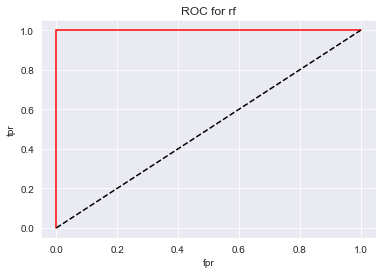

In [63]:
fpr, tpr, thresholds = roc_curve(train_y, train_pred)

plt.plot(fpr, tpr, 'r')
plt.plot([0,1], [0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC for rf')
plt.show()

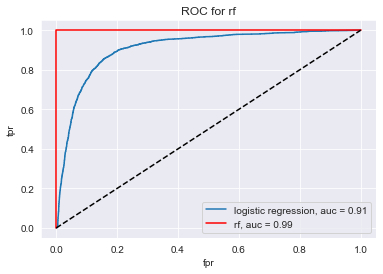

In [64]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(train_y, fitted_models['lr'].best_estimator_.predict_proba(train_X)[:,1])

plt.plot(fpr_lr, tpr_lr,  label= 'logistic regression, auc = {}'.format(round(fitted_models['lr'].best_score_,2)))
plt.plot(fpr, tpr, 'r', label = 'rf, auc = {}'.format(round(fitted_models['rf'].best_score_, 2)))
plt.plot([0,1], [0,1],'k--')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC for rf')
plt.show()

<div class='alert alert-info'>
    
**Both RandomForestClassifier and XGBClassifier have high cv score, either model would be good enough for project delivery. We will use RandomForestClassifier at this point as it has slightly better scores.**

In [24]:
# save the models for future reference
with open('../models/fitted_models.pkl', 'wb') as f:
    pickle.dump(fitted_models, f)

[back to top](#toc)
<a id = 'eval'></a>
### 3. Model Evaluation

In [27]:
# calculate roc score on test set
roc_auc_score(test_y, best_model.predict_proba(test_X)[:,1])

0.9863251469748273

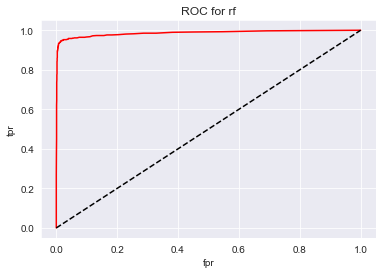

In [65]:
fpr, tpr, thresholds = roc_curve(test_y, best_model.predict_proba(test_X)[:,1])

plt.plot(fpr, tpr, 'r')
plt.plot([0,1], [0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC for rf')
plt.show()

In [67]:
roc_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold': thresholds})
roc_df.head()

,fpr,tpr,threshold
0,0.000000,0.000000,2.000
1,0.000000,0.267459,1.000
2,0.000467,0.377415,0.995
3,0.000934,0.451709,0.990
4,0.000934,0.508172,0.985


In [78]:
roc_df[roc_df.tpr > 0.9].head()

,fpr,tpr,threshold
45,0.004204,0.900446,0.605
46,0.004671,0.901932,0.595
47,0.005138,0.901932,0.590
48,0.005138,0.910847,0.515
49,0.005605,0.910847,0.505


In [88]:
# create two columns for simple look up, 1 is sampleSize, which is the percentage of total samples by corresponding threshold
# the other is Accuracy, which tells users how many chosen ones are actually going to leave by corresponding threshold 
roc_df.loc[:, 'sampleSize'] = roc_df.tpr * test_y.mean() + roc_df.fpr * (1-test_y.mean())
roc_df.loc[:, 'Accuracy'] = (roc_df.tpr * test_y.mean())/roc_df.sampleSize
roc_df.head()

,fpr,tpr,threshold,sampleSize,Accuracy
0,0.000000,0.000000,2.000,0.000000,NaN
1,0.000000,0.267459,1.000,0.063966,1.000000
2,0.000467,0.377415,0.995,0.090618,0.996078
3,0.000934,0.451709,0.990,0.108742,0.993464
4,0.000934,0.508172,0.985,0.122246,0.994186


In [96]:
# e.g. we can reach 95% of employees who are leaving by interviewing the top 25% of the employees
# ranked from most likely to least likely, with an accuracy of 90%
roc_df[roc_df.Accuracy > 0.9].tail()

,fpr,tpr,threshold,sampleSize,Accuracy
82,0.027090,0.952452,0.215,0.248401,0.917024
83,0.028024,0.952452,0.205,0.249112,0.914408
84,0.029426,0.952452,0.195,0.250178,0.910511
85,0.032228,0.952452,0.190,0.252310,0.902817
86,0.032695,0.952452,0.185,0.252665,0.901547


In [97]:
#savet the reference table
roc_df.to_csv('../delieverables/interview-sample-size-reference.csv')

**Feature importance**

In [35]:
def plot_feature_importance(feat_names, feat_imps, title = 'feature importance', method = 'Gini importance'):
    feat_imp_dict = dict(zip(feat_names, feat_imps))
    feat_imp_df = pd.DataFrame.from_dict(feat_imp_dict, orient = 'index').rename(columns = {0: method})
    feat_imp_df.sort_values(method).plot(kind = 'barh')
    plt.title(title)
    plt.show()

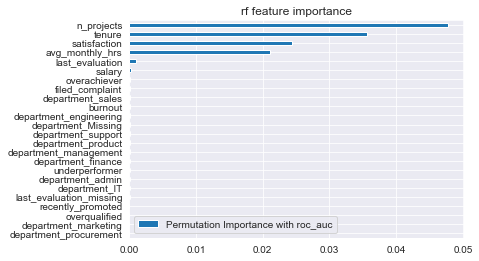

In [54]:
# rf - permutation - roc - train
imp_pm_train_roc = permutation_importance(best_model, train_X, train_y, scoring = 'roc_auc', n_repeats=10, random_state=26, n_jobs=-2).importances_mean
plot_feature_importance(train_X.columns, imp_pm_train_roc, title = 'rf feature importance', method = 'Permutation Importance with roc_auc')

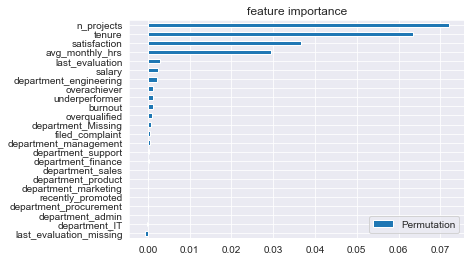

CPU times: user 5.36 s, sys: 897 ms, total: 6.25 s
Wall time: 18.8 s


In [44]:
# rf - permutation - roc -test
%%time
imp_pm_test = permutation_importance(best_model, test_X, test_y, scoring = 'roc_auc', n_repeats=10, random_state=26, n_jobs=-2).importances_mean
plot_feature_importance(test_X.columns, imp_pm_test, method = 'Permutation')

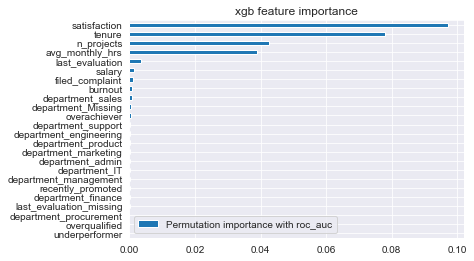

CPU times: user 911 ms, sys: 68.7 ms, total: 980 ms
Wall time: 15.9 s


In [61]:
%%time
imp_pm_train_roc = permutation_importance(fitted_models['xgb'].best_estimator_, train_X, train_y, scoring = 'roc_auc', n_repeats=10, random_state=26, n_jobs=-2).importances_mean
plot_feature_importance(train_X.columns, imp_pm_train_roc, title = 'xgb feature importance', method = 'Permutation importance with roc_auc')

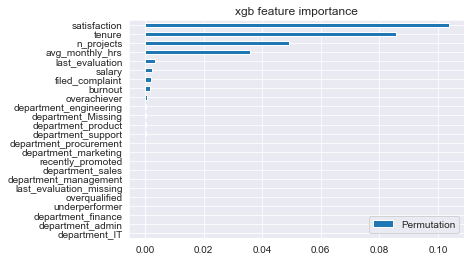

In [62]:
# xgb-permutation-roc-test
imp_pm_test = permutation_importance(fitted_models['xgb'].best_estimator_, test_X, test_y, scoring = 'roc_auc', n_repeats=10, random_state=26, n_jobs=-2).importances_mean
plot_feature_importance(test_X.columns, imp_pm_test,title = 'xgb feature importance', method = 'Permutation')

**CONCLUSION**: 

1. Our final model generalizes quite well on the test set, we achieved **0.98** roc-auc score, which is high accurate.
2. A table is generated to guide clients on interview sample size as well as expected accuracy rate for reaching the right employee. **e.g., for every 100 employees, we expect 23 will leave the company. With the probability generated from our model and sorting it from the most likely to leave to the least, HR could interview the top 25 employees on the list and ultimately reach out to 22 out of the 23 likely leavers.** As a result, HR could choose the most appropriate sample size based on their availble resources.
3. The most importnat features for our prediction model include **n_projects, tenure, satisfaction, avg_monthly_hrs.**


[back to top](#toc)
<a id = 'refit'></a>
### 4. Refit Model on Entire Dataset

In [119]:
X.shape

(14068, 24)

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14068 entries, 0 to 14067
Data columns (total 24 columns):
avg_monthly_hrs            14068 non-null int64
filed_complaint            14068 non-null float64
last_evaluation            14068 non-null float64
n_projects                 14068 non-null int64
recently_promoted          14068 non-null float64
salary                     14068 non-null int64
satisfaction               14068 non-null float64
tenure                     14068 non-null float64
last_evaluation_missing    14068 non-null int64
underperformer             14068 non-null int64
overqualified              14068 non-null int64
overachiever               14068 non-null int64
burnout                    14068 non-null int64
department_IT              14068 non-null int64
department_Missing         14068 non-null int64
department_admin           14068 non-null int64
department_engineering     14068 non-null int64
department_finance         14068 non-null int64
department_manage

In [100]:
final_model = fitted_models['rf'].best_estimator_.fit(X, y)

In [101]:
roc_auc_score(y, final_model.predict_proba(X)[:,1])

1.0

[back to top](#toc)
<a id = 'save'></a>
### 5. Save Model

In [102]:
with open ('../models/final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [103]:
# check the model is saved correctly:
with open('../models/final_model.pkl','rb') as f:
    saved_final_model = pickle.load(f)

In [104]:
score = roc_auc_score(y, final_model.predict_proba(X)[:, 1])

In [105]:
score

1.0

In [106]:
with open('../models/final_model_auc.pkl', 'wb') as f:
    pickle.dump(score, f)

In [107]:
with open('../models/final_model_auc.pkl', 'rb') as f:
    score = pickle.load(f)

In [108]:
score

1.0

[back to top](#toc)